In [59]:
import unicodedata
import igviz as ig
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sys

sys.path.append('../src')
import utils

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Borders dataset 
Taken from: 
    https://github.com/geodatasource/country-borders

In [4]:
brd_df = pd.read_csv('../data/land_borders.CSV')
brd_df.head()

,country_code,country_name,country_border_code,country_border_name
0,AD,Andorra,FR,France
1,AD,Andorra,ES,Spain
2,AE,United Arab Emirates,OM,Oman
3,AE,United Arab Emirates,SA,Saudi Arabia
4,AF,Afghanistan,CN,China


In [5]:
# standardize
brd_df = brd_df.applymap(lambda s:s.lower() if type(s) == str else s)
brd_df = brd_df.dropna()

In [6]:
# rename columns
brd_df.rename(columns={"country_name": "country",
                   "country_code": "country_code",
                   "country_border_name": "neighbor", 
                   "country_border_code":  "neighbor_code"}, inplace = True)

In [7]:
brd_df.head()

,country_code,country,neighbor_code,neighbor
0,ad,andorra,fr,france
1,ad,andorra,es,spain
2,ae,united arab emirates,om,oman
3,ae,united arab emirates,sa,saudi arabia
4,af,afghanistan,cn,china


## Coordinates dataset  

WorkBank API: http://api.worldbank.org/v2/country/?format=json

Taken from: 
    https://gist.github.com/tadast/8827699#file-countries_codes_and_coordinates-csv

In [8]:
# http://techslides.com/list-of-countries-and-capitals#google_vignette
coord_df = pd.read_csv('../data/country-capitals.csv')

In [10]:
new_row = {'CountryName': 'French Guiana', 
           'CapitalName': 'Cayenne', 
           'CapitalLatitude':4.9372, 
           'CapitalLongitude':-52.326, 
           'CountryCode':'GF',
           'ContinentName': 'America'}
#append row to the dataframe
coord_df = coord_df.append(new_row, ignore_index=True)

In [11]:
# standardize
coord_df = coord_df.applymap(lambda s:s.lower() if type(s) == str else s)
## removes special characters
coord_df = coord_df.applymap(lambda s:unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode("utf-8") if type(s) == str else s)
coord_df.tail()

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
240,hong kong,NaN,0.0000,0.000,hk,asia
241,heard island and mcdonald islands,NaN,0.0000,0.000,hm,antarctica
242,british indian ocean territory,diego garcia,-7.3000,72.400,io,africa
243,macau,NaN,0.0000,0.000,mo,asia
244,french guiana,cayenne,4.9372,-52.326,gf,america


In [12]:
coord_df.rename(columns={"CountryName": "country",
                       "CapitalName": "capital",
                       "CountryCode": "country_code",
                       "CapitalLongitude": "longitude",
                       "CapitalLatitude": "latitude",
                       "ContinentName": "continent"}, 
                        inplace = True)

coord_df_filt = coord_df.copy()[['country_code','latitude', 'longitude', 'continent']]
coord_df_filt.dropna(inplace=True)
coord_df_filt.head()

,country_code,latitude,longitude,continent
1,gs,-54.283333,-36.500000,antarctica
2,tf,-49.350000,70.216667,antarctica
3,ps,31.766667,35.233333,asia
4,ax,60.116667,19.900000,europe
5,nr,-0.547700,166.920867,australia


# Using average coordinates for better visualziation

In [34]:
## Other approach
coord_df_2 = pd.read_csv('../data/countries_codes_and_coordinates.csv')
coord_df_2.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,"""AF""","""AFG""","""4""","""33""","""65"""
1,Albania,"""AL""","""ALB""","""8""","""41""","""20"""
2,Algeria,"""DZ""","""DZA""","""12""","""28""","""3"""
3,American Samoa,"""AS""","""ASM""","""16""","""-14.3333""","""-170"""
4,Andorra,"""AD""","""AND""","""20""","""42.5""","""1.6"""


In [35]:
# Clean characters
coord_df_2[coord_df_2.columns] = coord_df_2[coord_df_2.columns].replace({'\"':''}, regex=True)
coord_df_2[coord_df_2.columns] = coord_df_2[coord_df_2.columns].replace({' ':''}, regex=True)

In [36]:
# rename columns
coord_df_2.rename(columns={"Country": "country",
                       "Alpha-2 code": "country_code",
                       "Latitude (average)": "latitude",
                       "Longitude (average)": "longitude"}, 
                        inplace = True)
coord_df_2 = coord_df_2[['country', 'country_code', 'latitude', 'longitude']]

In [37]:
num_list = ['latitude', 'longitude']
coord_df_2[num_list] = coord_df_2[num_list].apply(pd.to_numeric, errors='coerce')

In [38]:
# standardize
coord_df_2 = coord_df_2.applymap(lambda s:s.lower() if type(s) == str else s)

In [39]:
coord_df_filt2 = coord_df_2.copy()[['country_code','latitude', 'longitude']]
coord_df_filt2.dropna(inplace=True)
coord_df_filt2.head()

,country_code,latitude,longitude
0,af,33.0000,65.0
1,al,41.0000,20.0
2,dz,28.0000,3.0
3,as,-14.3333,-170.0
4,ad,42.5000,1.6


## Join dataframes

In [40]:
# First approach
full_df = pd.merge(brd_df, coord_df_filt, on='country_code', how='inner')
full_df.head()

,country_code,country,neighbor_code,neighbor,latitude,longitude,continent
0,ad,andorra,fr,france,42.500000,1.516667,europe
1,ad,andorra,es,spain,42.500000,1.516667,europe
2,ae,united arab emirates,om,oman,24.466667,54.366667,asia
3,ae,united arab emirates,sa,saudi arabia,24.466667,54.366667,asia
4,af,afghanistan,cn,china,34.516667,69.183333,asia


In [48]:
# second approach
full_df2 = pd.merge(brd_df, coord_df_filt2, on='country_code', how='inner')

## Create dictionary of coordinates

In [43]:
## to include as attribute
coords = list(zip(full_df['longitude'], full_df['latitude']))
dic_coords = {}
# create dictionary with positions
for pos, country_c in enumerate(full_df['country_code']):
    dic_coords[country_c] = coords[pos]

## https://stackoverflow.com/questions/42272710/networkx-how-to-assign-the-node-coordinates-as-attribute

## Number of neightbors


In [44]:
weigths = full_df.set_index(["country_code", "neighbor"]).count(level="country_code")['country'].reset_index()

dic_weight = {}
# create dictionary with positions
for pos, country_c in enumerate(weigths['country_code']):
    dic_weight[country_c] = weigths['country'][pos]

## Graph

In [52]:
G = nx.Graph()
G = nx.from_pandas_edgelist(full_df2, 'country_code', 'neighbor_code')
nx.set_node_attributes(G, dic_coords, 'coord')
#nx.set_node_attributes(G, dic_weight, 'value')

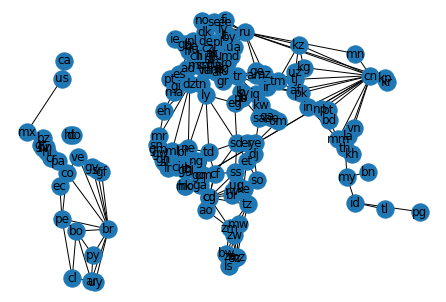

In [50]:
nx.draw(G, pos=dic_coords , with_labels=True)
plt.show()

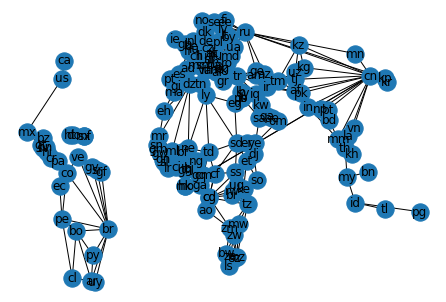

In [51]:
# apparently, there is no difference
G = nx.Graph()
G = nx.from_pandas_edgelist(full_df, 'country_code', 'neighbor_code')
nx.set_node_attributes(G, dic_coords, 'coord')
#nx.set_node_attributes(G, dic_weight, 'value')

nx.draw(G, pos=dic_coords , with_labels=True)
plt.show()

# Using [`pyvis`](https://pyvis.readthedocs.io/en/latest/index.html)

In [61]:
utils.draw_graph3(G, output_filename='graph_output.html', notebook=True)

## Dataframe without neighbors

In [ ]:
df_no_neighbors = df[df['neighbor'].isna()]

## Dataframe with neighbors

In [145]:
df_w_neighbors = df[df['neighbor'].notna()]